In [2]:
from eda_imports import *

import pysam
from tqdm import tqdm

import kleat.misc.settings as S
import kleat.misc.utils as U
from kleat.misc.apautils import calc_genome_offset
from kleat.evidence import bridge

from kleat.visaln import visaln

seaborn not found


In [3]:
# DATA_DIR='/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-TCGA-analysis-scripts/benchmark-kleat.bk/UHR/C1/tasrkleat-results'
DATA_DIR='../../kleat/'

In [4]:
# c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/c2g.bam'))
# r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/HBRC4/r2c_sorted.bam'))

c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/c2g.bam'))
r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/r2c_sorted.bam'))

In [5]:
# contig_name = 'A0.R100625'
# contig_name = 'E3.L.51'
# contig_name = 'E1.L.4362'

# contig_name = 'E1.S.23541'
# predicted_clvs = sorted([100264532, 100264530])

# contig_name = 'E1.S.24501'
# predicted_clvs = sorted([64657194, 64657270, 64657192])

contig_name = 'E0.L.50755'
predicted_clvs = sorted([130037417, 130037352, 130037347])

In [6]:
for contig in c2g_bam:
    if contig.query_name == contig_name:
#         if contig.reference_name == 'chr16' and contig.is_reverse:
            print(contig.cigarstring)
            break

24M5D221M


In [7]:
print(contig.query_name, contig.is_reverse, contig.reference_start)
print(contig.cigarstring)

E0.L.50755 False 130037323
24M5D221M


In [8]:
reads = r2c_bam.fetch(contig.query_name)
bdg_read_info = []
for rd in reads:
    if bridge.is_a_bridge_read(rd):
        if contig.is_reverse:
            contig_len = contig.infer_query_length(always=True)
            bdg_read_info.append([
                contig_len - rd.reference_end,
                contig_len - rd.reference_start,
                not rd.is_reverse,
                f'rev({rd.cigarstring})',
                tuple(reversed(rd.cigartuples))
            ])
        else:
            contig_len = contig.infer_query_length(always=True)            
            bdg_read_info.append([                
                rd.reference_start,
                rd.reference_end,
                rd.is_reverse,
                f'{rd.cigarstring}',
                rd.cigartuples
            ])

In [9]:
df_bdg_read = pd.DataFrame(bdg_read_info, columns=['reference_start', 'reference_end', 'is_reverse', 'cigarstring', 'cigartuples'])
df_bdg_read = df_bdg_read.sort_values('reference_start').reset_index(drop=True)

In [10]:
df_bdg_read.shape

(6, 5)

In [11]:
df_bdg_read

,reference_start,reference_end,is_reverse,cigarstring,cigartuples
0,24,90,False,6S66M1S,"[(4, 6), (0, 66), (4, 1)]"
1,24,91,True,7S67M,"[(4, 7), (0, 67)]"
2,24,93,True,4S69M,"[(4, 4), (0, 69)]"
3,24,93,True,5S69M,"[(4, 5), (0, 69)]"
4,24,93,True,5S69M,"[(4, 5), (0, 69)]"
5,24,93,True,3S69M,"[(4, 3), (0, 69)]"


In [12]:
contig_sr = pd.Series(
    [contig.reference_start, contig.reference_end, contig.cigarstring, contig.cigartuples], 
    index=['reference_start', 'reference_end', 'cigarstring', 'cigartuples']
)

In [13]:
contig_sr.to_frame().T

,reference_start,reference_end,cigarstring,cigartuples
0,130037323,130037573,24M5D221M,"[(0, 24), (2, 5), (0, 221)]"


In [14]:
# contig span
contig_sr.reference_end - contig_sr.reference_start

250

In [15]:
num_skips = visaln.calc_num_skips(contig)
# TODO: turn this into accepting predicted_clvs
df_xlims = visaln.calc_xlim_pairs(contig, predicted_clvs[0])

130037322 - 130037574, covering clv True


Text(0.5,1.02,'E0.L.50755, chr7, (+), clv: 130037417')

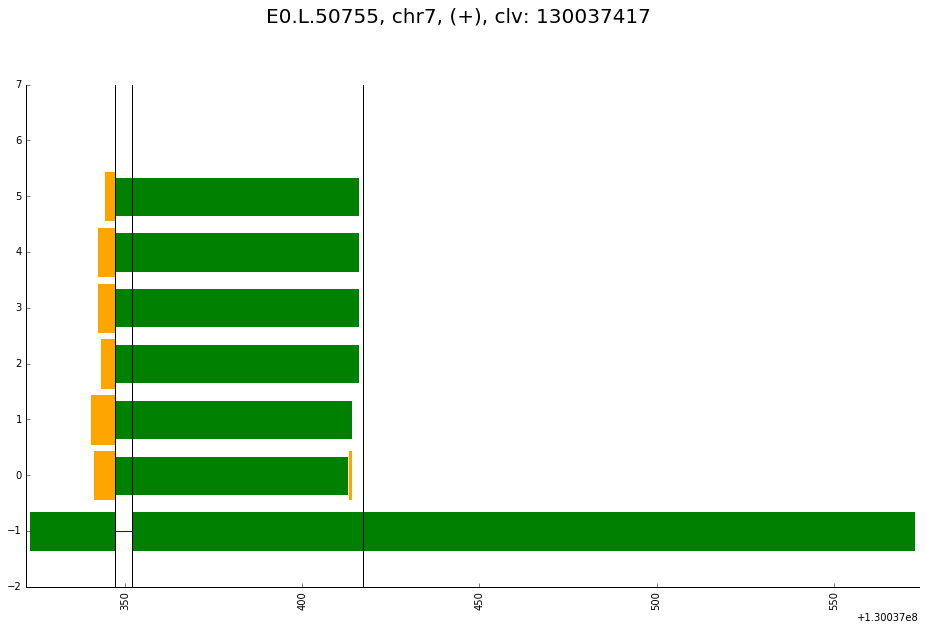

In [16]:
num_subplots = num_skips + 1
fig_height = df_bdg_read.shape[0] * 1.5

fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, fig_height), sharey=True, 
    gridspec_kw = {
        'width_ratios':df_xlims.span, 
        'hspace': 0.5
    }
)
if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
#         print(cx, end=', ')
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    for _clv in predicted_clvs:
        ax.plot([_clv, _clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= _clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    
    for tick in ax.get_xticklabels(): tick.set_rotation(90)    
    
    if ki > 0:
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ki == 0:
        ax.tick_params(top=False, right=False)
    if ki > 0:
        ax.tick_params(top=False, right=False, left=False)
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.reference_name}, ({strand}), clv: {_clv}', fontsize=20, y =1.02)
# plt.tight_layout()